# Titanic Dataset EDA:

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn

Preliminary analysis on Titanic Dataset for Kaggle competion:

In [16]:
#import the datasets
dataset = pd.read_csv('train.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can read in the data as above, using the pandas 'read_csv' function. Pandas also has methods to read other data formats, including excel sheets, sql files, text files, etc. Basically, if you can store data in it, pandas can probably read it in natively. It can also save dataframes into any file format, making storing an altered dataset fairly easy.

In [17]:
import pandas_profiling

In [18]:
dataset.shape

(891, 12)

We can also use methods like shape to see the size of the dataframe we are working with. This may look familiar to those who have used numpy before. This is because pandas functions as a wrapper over numpy, so a lot of the methods we use will be the same. In fact, a good way to think of a pandas dataframe is a as a collection of numpy arrays that have been 'prettied up'.

In [19]:
#Split into train and test data
train_ratio = 0.7
dataset_size = 891

train_data = dataset.sample(int(dataset_size*train_ratio))
test_data = dataset.sample(int(dataset_size*(1-train_ratio)))

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
209,210,1,1,"Blank, Mr. Henry",male,40.00,0,0,112277,31.000,A31,C
230,231,1,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.00,1,0,36973,83.475,C83,S
772,773,0,2,"Mack, Mrs. (Mary)",female,57.00,0,0,S.O./P.P. 3,10.500,E77,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.500,NaN,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.00,2,0,19928,90.000,C78,Q


We spit the data into training and testing data first, since this allows us to prevent 'data leakage'. This is when we compute values that are spread across the train and test data, eg. the mean of a particular column, that we may want to impute into blank values later. We don't want these values to be skewed by testing data, since the point of testing data is that we dont know what it is before we run our model on it. Using test data values to draw conclusions from which we will train our model is rather circular reasoning, and we avoid it by splitting up front. 
However, whenever we alter the train data, or impute values, we should be careful to alter the test data in the same way and impute the same values. Otherwise the shape of the data may change, and therefore our model will fail.

In [20]:
train_data.shape

(623, 12)

In [21]:
train_data.Survived.value_counts()

0    390
1    233
Name: Survived, dtype: int64

In [22]:
print("Baseline Accuracy")
train_data[train_data.Survived == 0].Survived.count() / train_data.Survived.count()

Baseline Accuracy


0.6260032102728732

We look into the target variable, in this case whether the passenger 'Survived' or not, as a way of setting our baseline accuracy, and seeing how skewed the data is. In this case, if we predict that every passenger will die, we will get an accuracy of about 60%. Our model whould ideally beat this in order to be considered at all useful.
Every problem will have a different required accuracy threshold. Lets say that in order to be successfull, we should hit at least 80% accuracy. Higher accuracies are possible on this dataset, but lets set a basic target for now.

## Feature Analysis: PClass

Feature describing the class of tickets that the passengers purchased. Intuition is that better tickets = better survival rate

In [7]:
train_data.Pclass.value_counts()

3    346
1    158
2    119
Name: Pclass, dtype: int64

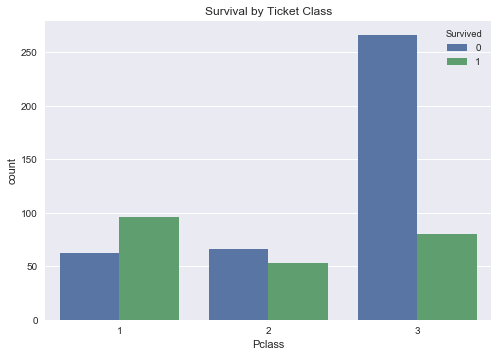

In [8]:
plt.title("Survival by Ticket Class")
sns.countplot(x='Pclass',hue='Survived',data=train_data)

Ratio of Survival is indeed higher the higher the ticket class.

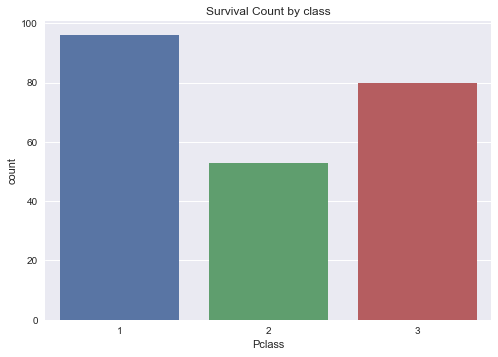

In [9]:
plt.title("Survival Count by class")
sns.countplot(x="Pclass",data=train_data[train_data.Survived==1])

Though the ratio of survival is higher in 2nd class than first class, more people overall survived from 3rd class than second class, likely as a consequence of the higher starting number in the first place. 1st class has the highest number of survivors and survival ratio both, even though the starting number wasn't that much higher than 2nd class. Suggests Priority was given mainly to 1st class, and not to other two classes.

## Feature Analysis: Name

In [10]:
train_data.Name.describe()

count                         623
unique                        623
top       Meyer, Mr. Edgar Joseph
freq                            1
Name: Name, dtype: object

Intuition that families either survived or perished together, need to check this:

In [11]:
#Going to split Name into First_Name and Last_Name, and create column for last name
def SplitName(name):
    name = name.split(',')
    last_name = name[0]
    return last_name

In [12]:
train_data['Last_Name'] = train_data.Name.apply(SplitName)

In [13]:
train_data.Last_Name.describe()

count           623
unique          494
top       Andersson
freq              6
Name: Last_Name, dtype: object

Assumption: Those with same last name belong in the same family.
Lets create a column for those with family on board.

In [14]:
#Counts number of same last names and return true if more than 1
def CheckForFamily(Last_Name):
    last_name_count = train_data.Last_Name[train_data.Last_Name == Last_Name].count()
    if last_name_count > 1:
        return 1
    return 0

In [15]:
train_data['Has_Family'] = train_data.Last_Name.apply(CheckForFamily)

In [16]:
train_data.Has_Family.value_counts()

0    410
1    213
Name: Has_Family, dtype: int64

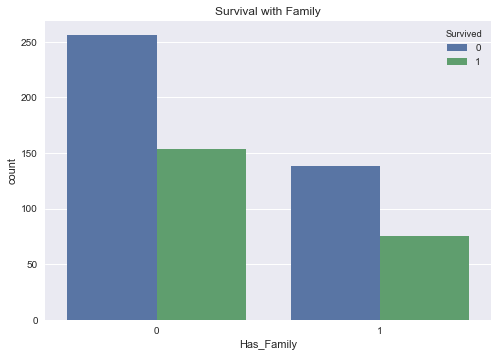

In [17]:
plt.title("Survival with Family")
sns.countplot(x='Has_Family',hue='Survived',data=train_data)

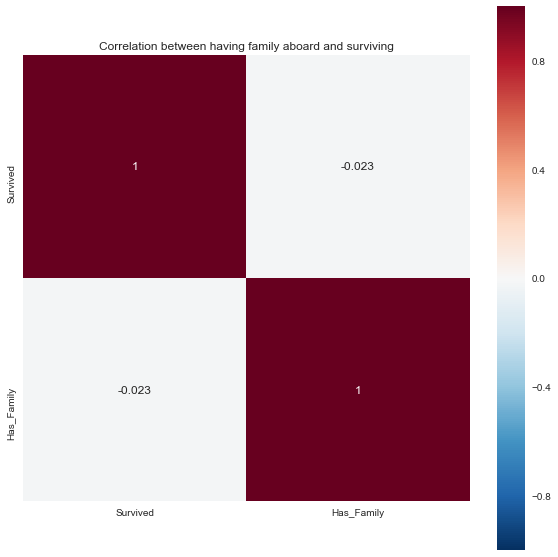

In [18]:
family_survival_corr = train_data[['Survived','Has_Family']].corr()
plt.figure(figsize=(10,10))
plt.title("Correlation between having family aboard and surviving")
sns.heatmap(family_survival_corr,annot=True,square=True)

There is almost 0 correlation between having family on board and the survival rate, so it seems my intuition was wrong. 

In [19]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Has_Family
260,261,0,3,"Smith, Mr. Thomas",male,NaN,0,0,384461,7.7500,NaN,Q,Smith,1
155,156,0,1,"Williams, Mr. Charles Duane",male,51.0,0,1,PC 17597,61.3792,NaN,C,Williams,1
613,614,0,3,"Horgan, Mr. John",male,NaN,0,0,370377,7.7500,NaN,Q,Horgan,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S,Nysveen,0
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.0,0,0,250646,13.0000,NaN,S,Givard,0


## Feature Analysis: Sex

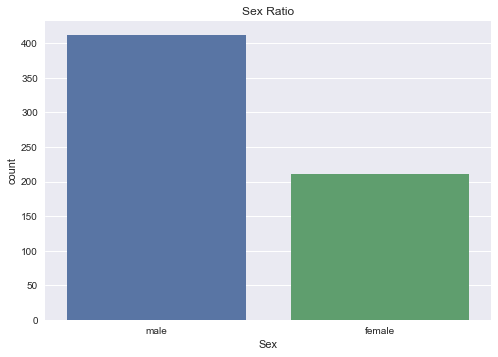

In [20]:
plt.title("Sex Ratio")
sns.countplot(train_data.Sex)

More males than females were aboard the ship, so if survival was random, we would expect more males to survive. However, it is probable the opposite happened due to the prevailing social attitudes.

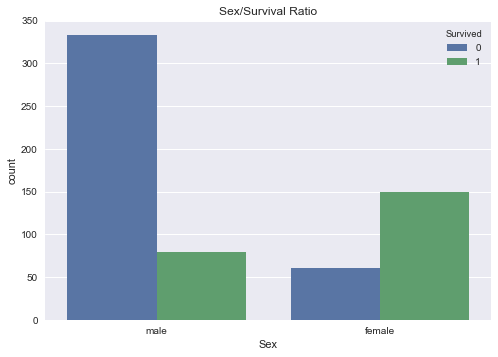

In [21]:
plt.title("Sex/Survival Ratio")
sns.countplot(x='Sex',hue='Survived',data=train_data)

As expected more females survived than males, likely due to the "women and children first" mentality of the era. To check this causal theory, lets cross-reference survival with sex and age.

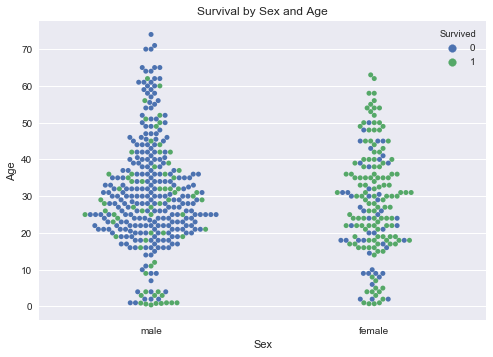

In [22]:
plt.title('Survival by Sex and Age')
sns.swarmplot(x='Sex',y='Age',hue='Survived',data=train_data)

No immediate conclusion can be drawn from this swarmplot, lets analyse this in the next feature of Age.

## Feature Analysis: Age

As stated above, assumption is that lower age will correlate to higher survival rates. Lets test to what extent this is correct.

In [23]:
train_data.Age.describe()

count    503.000000
mean      29.637515
std       14.661447
min        0.420000
25%       20.750000
50%       28.500000
75%       38.000000
max       74.000000
Name: Age, dtype: float64

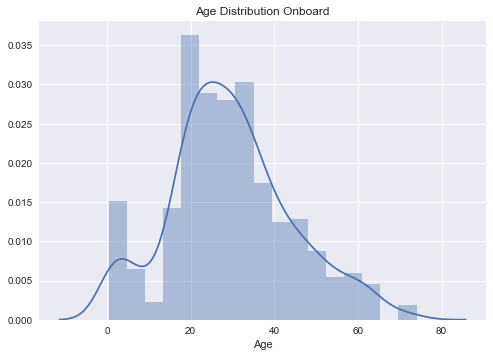

In [24]:
plt.title('Age Distribution Onboard')
sns.distplot(train_data.Age[train_data.Age.notnull()])

In [25]:
train_data.Age.isnull().sum()

120

In [26]:
train_data[train_data.Age.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Has_Family
260,261,0,3,"Smith, Mr. Thomas",male,NaN,0,0,384461,7.7500,NaN,Q,Smith,1
613,614,0,3,"Horgan, Mr. John",male,NaN,0,0,370377,7.7500,NaN,Q,Horgan,0
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C,Peter,0
560,561,0,3,"Morrow, Mr. Thomas Rowan",male,NaN,0,0,372622,7.7500,NaN,Q,Morrow,0
368,369,1,3,"Jermyn, Miss. Annie",female,NaN,0,0,14313,7.7500,NaN,Q,Jermyn,0
364,365,0,3,"O'Brien, Mr. Thomas",male,NaN,1,0,370365,15.5000,NaN,Q,O'Brien,1
568,569,0,3,"Doharr, Mr. Tannous",male,NaN,0,0,2686,7.2292,NaN,C,Doharr,0
598,599,0,3,"Boulos, Mr. Hanna",male,NaN,0,0,2664,7.2250,NaN,C,Boulos,1
168,169,0,1,"Baumann, Mr. John D",male,NaN,0,0,PC 17318,25.9250,NaN,S,Baumann,0
522,523,0,3,"Lahoud, Mr. Sarkis",male,NaN,0,0,2624,7.2250,NaN,C,Lahoud,0


Because some of the age values are missing, we have to impute them. However, imputing the mean or median might skew the data, so instead we will impute the data based on title. Eg: "Mr","Mrs", and "Miss". 
As a offshoot of this, we will assume that if they have parents aboard according to the "Parch" field, they are a child and therefore belong in a younger category. 

In [27]:
#Extract Title to separate field
def ExtractTitle(name):
    name = name.split(',')
    last_name = name[1].split('.')
    title = last_name[0]
    return title

In [230]:
#Clean titles into 4 categories
def CleanTitle(title):
    
    title=title.strip(' ')
    
    title_equivalents_dict = {'Miss':["Miss","Ms","Mlle"],'Mr':['Mr','Rev','Dr','Col','Major','Jonkheer','Capt','Don','Sir'],
                             'Mrs':['Mrs','Mme','the Countess','Lady','Dona'],'Master':['Master']}
    
    main_titles_lst = ['Miss','Mr','Mrs','Master']
    
    title_to_return = title
    
    for main_title in main_titles_lst:
        if title in title_equivalents_dict[main_title]:
            title_to_return = main_title
            
    return title_to_return

In [29]:
train_data['Title'] = train_data.Name.apply(ExtractTitle)
train_data['Title']=train_data.Title.apply(CleanTitle)

In [30]:
train_data.Title.value_counts()

Mr        380
Miss      125
Mrs        85
Master     33
Name: Title, dtype: int64

In [31]:
#Create function to return dict of average ages of each age category
def CalculateAverageAge():
    avg_ages_by_title = {'Mr':0,'Mrs':0,'Miss':0,'Master':0}
    title_lst = ['Mr','Mrs','Miss','Master']
    for title in title_lst:
        title_data = train_data[train_data.Title==title]
        avg_age = title_data.Age.mean()
        avg_ages_by_title[title] = avg_age
    return avg_ages_by_title

In [32]:
avg_ages_by_title = CalculateAverageAge()
print(avg_ages_by_title)

{'Mr': 33.04318936877076, 'Mrs': 35.986486486486484, 'Miss': 21.98989898989899, 'Master': 4.19551724137931}


In [33]:
def ImputeAverageAge(title,avg_ages_by_title):
    return avg_ages_by_title[title]

In [34]:
#Create column with average age for each person
avg_ages_by_title = CalculateAverageAge()
train_data['Avg_Ages'] = train_data.Title.apply(lambda title: ImputeAverageAge(title,avg_ages_by_title))

In [35]:
train_data.Avg_Ages.describe()

count    623.000000
mean      29.698961
std        7.660703
min        4.195517
25%       21.989899
50%       33.043189
75%       33.043189
max       35.986486
Name: Avg_Ages, dtype: float64

In [36]:
#Fill blank values in Age with corresponding Avg_Ages value
train_data['Age']=train_data.Age.fillna(train_data['Avg_Ages'])

In [37]:
train_data.drop(['Avg_Ages'],axis=1,inplace= True)

In [38]:
train_data.Age.describe()

count    623.000000
mean      29.698961
std       13.500988
min        0.420000
25%       21.989899
50%       30.000000
75%       35.986486
max       74.000000
Name: Age, dtype: float64

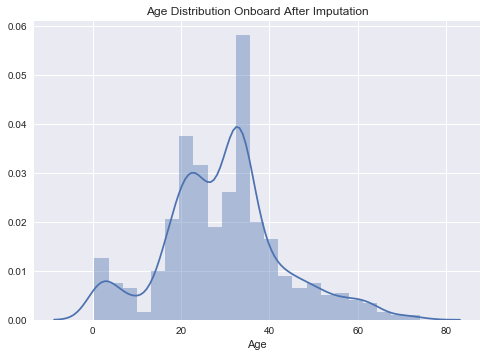

In [39]:
plt.title('Age Distribution Onboard After Imputation')
sns.distplot(train_data.Age[train_data.Age.notnull()])

The Age column has successfully been imputed with blank values so as to cause minimum disruption to the overall trends in distribution. Now let us look at survival rates pertaining to age.

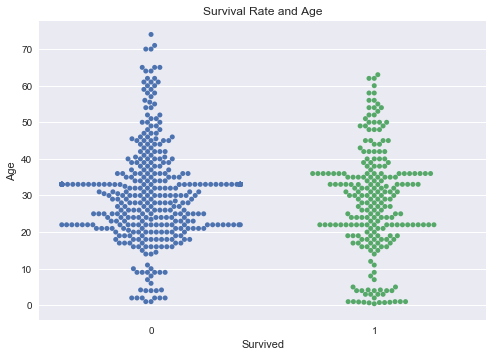

In [40]:
plt.title('Survival Rate and Age')
sns.swarmplot(y='Age',x='Survived',data=train_data)

It is difficult to tell anything from this swarmplot. Lets try dividing the group into minors and majors, and see if that impacts survival rate.

In [41]:
def CheckIfMinor(age):
    if age < 18:
        return 1
    return 0

In [42]:
train_data['Is_Minor'] = train_data.Age.apply(CheckIfMinor)

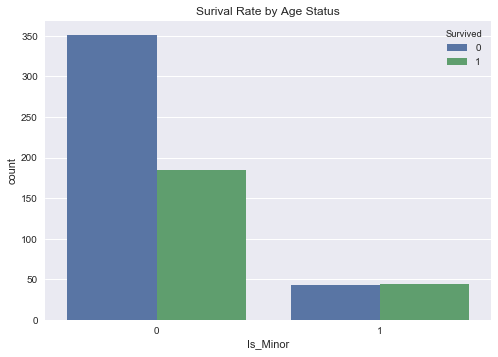

In [43]:
plt.title('Surival Rate by Age Status')
sns.countplot(x='Is_Minor',hue='Survived',data=train_data)

What this chart shows us is that the survival rate among minors was indeed greater than majors, with a little over half of all minors surviving.

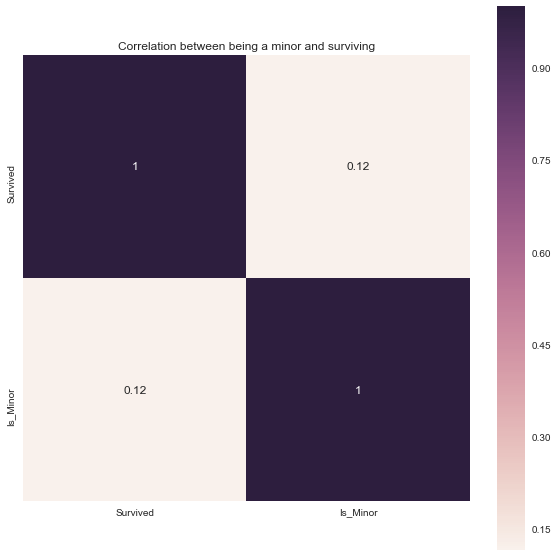

In [44]:
minor_survival_corr = train_data[['Survived','Is_Minor']].corr()
plt.figure(figsize=(10,10))
plt.title("Correlation between being a minor and surviving")
sns.heatmap(minor_survival_corr,annot=True,square=True)

This heatmap shows us that the correlation between minors and survival is there, but is not strong, so individually this feature won't help that much.

In [45]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Has_Family,Title,Is_Minor
260,261,0,3,"Smith, Mr. Thomas",male,33.043189,0,0,384461,7.7500,NaN,Q,Smith,1,Mr,0
155,156,0,1,"Williams, Mr. Charles Duane",male,51.000000,0,1,PC 17597,61.3792,NaN,C,Williams,1,Mr,0
613,614,0,3,"Horgan, Mr. John",male,33.043189,0,0,370377,7.7500,NaN,Q,Horgan,0,Mr,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.000000,0,0,345364,6.2375,NaN,S,Nysveen,0,Mr,0
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.000000,0,0,250646,13.0000,NaN,S,Givard,0,Mr,0


## Feature Analysis: SibSp and Parch

We briefly covered this in the Name feature, but now we have a chance to do it properly, without the shaky logic involved with Last Names. Again, I suspect that we will find a correlation between family and survival, but as with before, this is only a guess.

In [46]:
#Create field Num_Family by adding Parch and SibSp fields.
train_data['Num_Family']  = train_data['SibSp'] + train_data['Parch']

In [47]:
#Rework Has_Family to simply check that Num_Family is non-zero
def CheckForFamily(num_family):
    if num_family > 0:
        return 1
    return 0

In [48]:
train_data['Has_Family'] = train_data.Num_Family.apply(CheckForFamily)

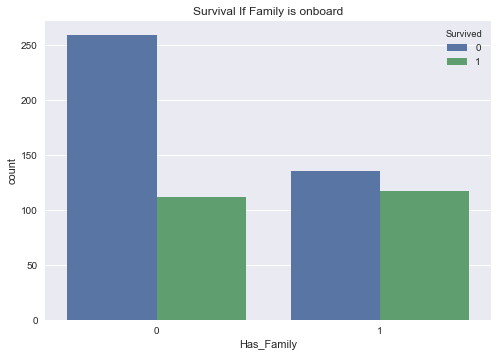

In [49]:
plt.title('Survival If Family is onboard')
sns.countplot(x='Has_Family',hue='Survived',data=train_data)

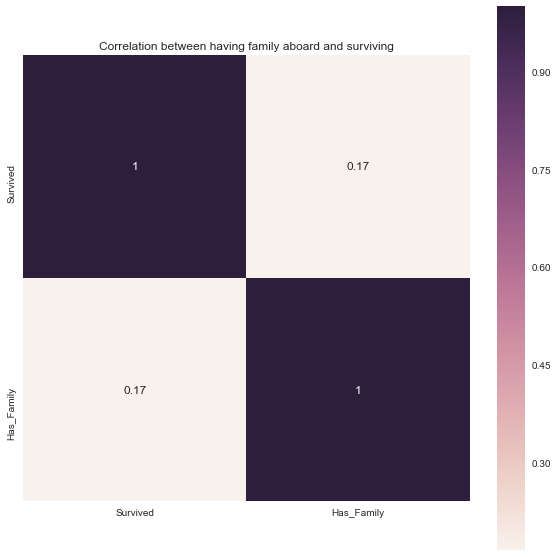

In [50]:
family_survival_corr = train_data[['Survived','Has_Family']].corr()
plt.figure(figsize=(10,10))
plt.title("Correlation between having family aboard and surviving")
sns.heatmap(family_survival_corr,annot=True,square=True)

There is indeed a positive correlation between having family onboard and surviving, but it is a weak correlation. We can intuit that this is because wherever possible, the families were placed on the boats together.

In [51]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Has_Family,Title,Is_Minor,Num_Family
260,261,0,3,"Smith, Mr. Thomas",male,33.043189,0,0,384461,7.7500,NaN,Q,Smith,0,Mr,0,0
155,156,0,1,"Williams, Mr. Charles Duane",male,51.000000,0,1,PC 17597,61.3792,NaN,C,Williams,1,Mr,0,1
613,614,0,3,"Horgan, Mr. John",male,33.043189,0,0,370377,7.7500,NaN,Q,Horgan,0,Mr,0,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.000000,0,0,345364,6.2375,NaN,S,Nysveen,0,Mr,0,0
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.000000,0,0,250646,13.0000,NaN,S,Givard,0,Mr,0,0


## Feature Analysis: Fare

I am pretty sure that Fare will reflect the same trends that PClass did, namely that the higher the fare, the better the survival chance. Lets look and see if this was the case.

In [52]:
train_data.Fare.describe()

count    623.000000
mean      31.714753
std       48.115421
min        0.000000
25%        7.925000
50%       15.045800
75%       30.847900
max      512.329200
Name: Fare, dtype: float64

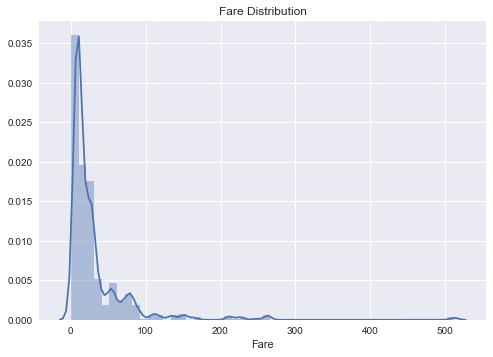

In [53]:
plt.title('Fare Distribution')
sns.distplot(train_data.Fare)

This field is highly skewed to the left, as there were more lower class passengers than upper class. There also seem to be major fluctuations in the fare prices. Lets look at the average fare prices per ticket class.

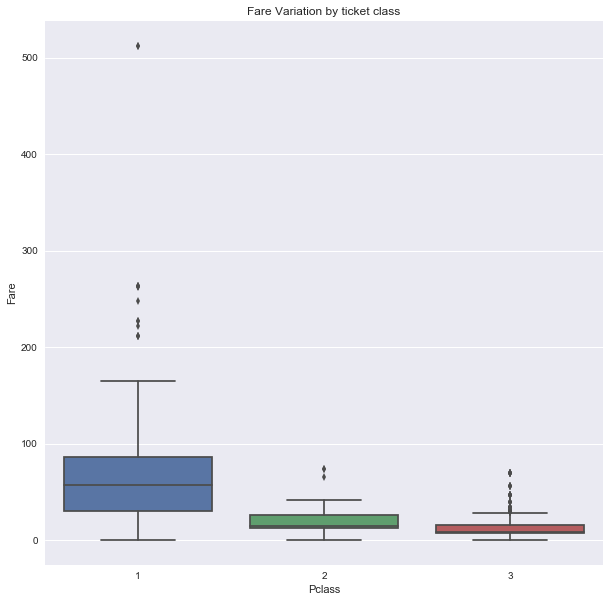

In [54]:
plt.figure(figsize=(10,10))
plt.title('Fare Variation by ticket class')
sns.boxplot(x='Pclass',y='Fare',data=train_data)

There are massive fluctions in ticket prices that can be explored later. For now, lets get on with correlating this with survival.

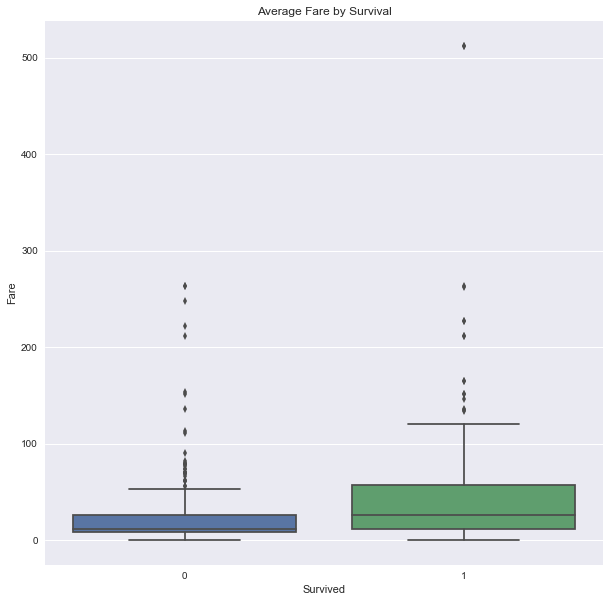

In [55]:
plt.figure(figsize=(10,10))
plt.title('Average Fare by Survival')
sns.boxplot(x='Survived',y='Fare',data=train_data)

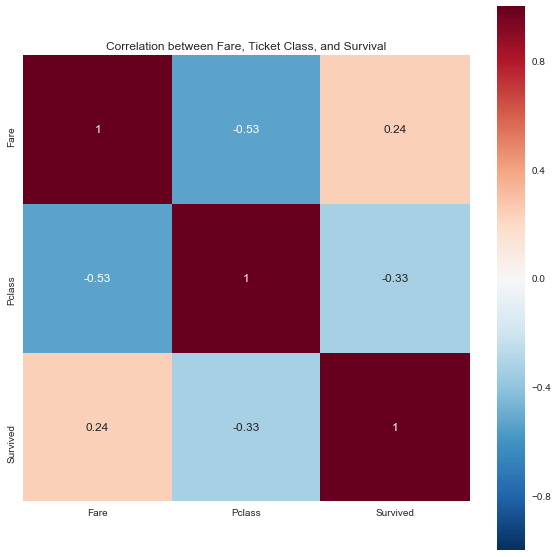

In [56]:
fare_survival_corr = train_data[['Fare','Pclass','Survived']].corr()
plt.figure(figsize=(10,10))
plt.title('Correlation between Fare, Ticket Class, and Survival')
sns.heatmap(fare_survival_corr,annot=True,square=True)

There is a stronger correlation between Pclass and Survival than between Fare and Survival, so in the final model we will probably use Pclass as a feature instead of Fare.

In [57]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Has_Family,Title,Is_Minor,Num_Family
260,261,0,3,"Smith, Mr. Thomas",male,33.043189,0,0,384461,7.7500,NaN,Q,Smith,0,Mr,0,0
155,156,0,1,"Williams, Mr. Charles Duane",male,51.000000,0,1,PC 17597,61.3792,NaN,C,Williams,1,Mr,0,1
613,614,0,3,"Horgan, Mr. John",male,33.043189,0,0,370377,7.7500,NaN,Q,Horgan,0,Mr,0,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.000000,0,0,345364,6.2375,NaN,S,Nysveen,0,Mr,0,0
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.000000,0,0,250646,13.0000,NaN,S,Givard,0,Mr,0,0


## Feature Analysis: Cabin

I just really want to know what the deal is with the Cabins

In [58]:
train_data.Cabin.value_counts()

C23 C25 C27    3
F4             2
C78            2
C124           2
C52            2
D17            2
B28            2
D              2
C93            2
B51 B53 B55    2
E44            2
B35            2
C123           2
E101           2
E25            2
C22 C26        2
E33            2
E24            2
E67            2
D20            2
B96 B98        2
B22            2
B20            2
B94            1
D28            1
C104           1
C118           1
C46            1
B18            1
F G73          1
              ..
C50            1
B42            1
C82            1
B3             1
D21            1
A24            1
C111           1
C85            1
B58 B60        1
D47            1
C91            1
C126           1
C68            1
D30            1
G6             1
B50            1
B73            1
B86            1
C30            1
A16            1
B5             1
B49            1
D10 D12        1
B38            1
C95            1
B77            1
F E69          1
A7            

I am guessing that Cabins likely indicate either crew members or first class passengers, and thus is an indicator of likely survival.

In [59]:
train_data.Cabin.fillna('None',inplace=True)

In [60]:
#See if the passenger had a cabin
def CheckForCabin(cabin):
    if cabin == 'None':
        return 0
    return 1

In [61]:
train_data['HasCabin'] = train_data.Cabin.apply(CheckForCabin)

Now that we have quantified which passengers had cabins, lets see if its true higher class patrons had cabins.

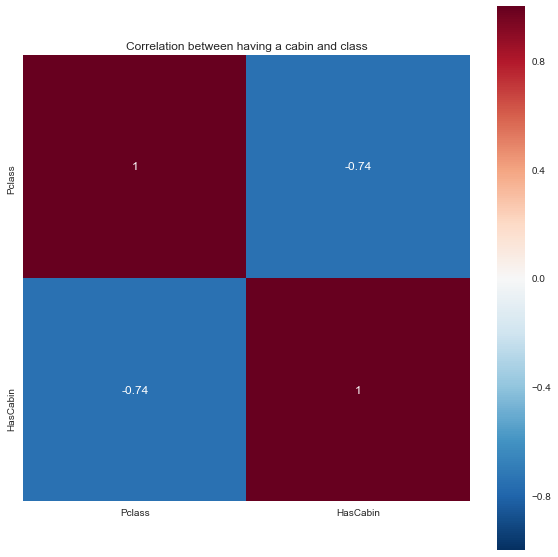

In [62]:
cabin_pclass_corr = train_data[['Pclass','HasCabin']].corr()
plt.figure(figsize=(10,10))
plt.title('Correlation between having a cabin and class')
sns.heatmap(cabin_pclass_corr,annot=True,square=True)

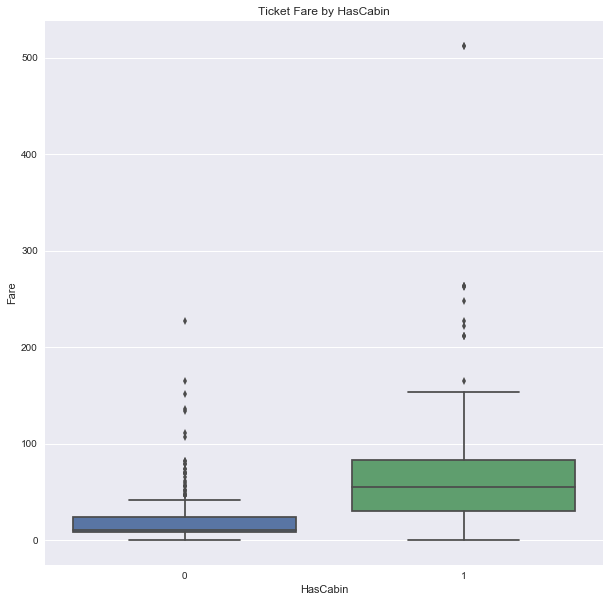

In [63]:
plt.figure(figsize=(10,10))
plt.title('Ticket Fare by HasCabin')
sns.boxplot(x='HasCabin',y='Fare',data=train_data)

We were right! Richer passengers had cabins. Now lets see if they tended to survive more.

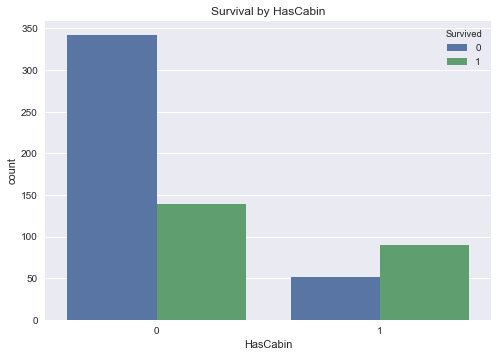

In [64]:
plt.title('Survival by HasCabin')
sns.countplot(x='HasCabin',hue='Survived',data=train_data)

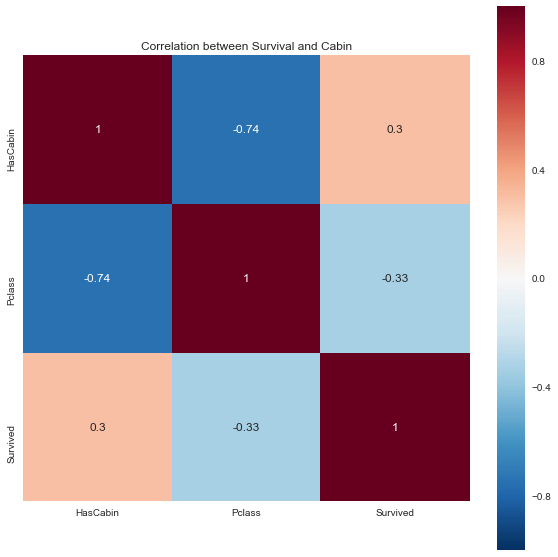

In [65]:
cabin_survival_corr = train_data[['HasCabin','Pclass','Survived']].corr()
plt.figure(figsize=(10,10))
plt.title('Correlation between Survival and Cabin')
sns.heatmap(cabin_survival_corr,annot=True,square=True)

In [66]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Has_Family,Title,Is_Minor,Num_Family,HasCabin
260,261,0,3,"Smith, Mr. Thomas",male,33.043189,0,0,384461,7.7500,None,Q,Smith,0,Mr,0,0,0
155,156,0,1,"Williams, Mr. Charles Duane",male,51.000000,0,1,PC 17597,61.3792,None,C,Williams,1,Mr,0,1,0
613,614,0,3,"Horgan, Mr. John",male,33.043189,0,0,370377,7.7500,None,Q,Horgan,0,Mr,0,0,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.000000,0,0,345364,6.2375,None,S,Nysveen,0,Mr,0,0,0
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.000000,0,0,250646,13.0000,None,S,Givard,0,Mr,0,0,0


## Feature Analysis: Embarked

Lets see if where the passengers got on had any affect on their survival, though I do not anticipate this being the case.

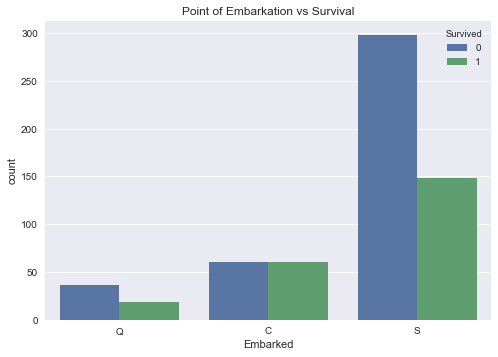

In [67]:
plt.title('Point of Embarkation vs Survival')
sns.countplot(x='Embarked',hue='Survived',data=train_data)

Strangely, it seems that the point of embarkation does seem to matter in survival. However, it seems likely that this is a correlation caused more by outside factors, possibly correlating to social position and ticket class.

To study this further, I want to see how many people from each point where in each Pclass.

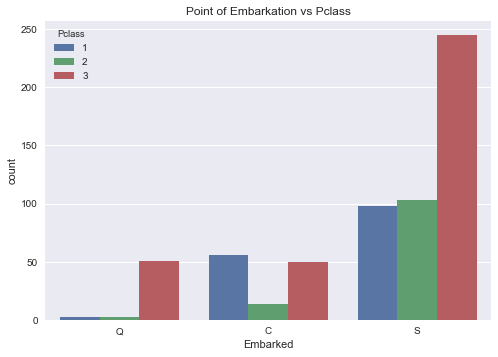

In [68]:
plt.title('Point of Embarkation vs Pclass')
sns.countplot(x='Embarked',hue='Pclass',data=train_data)

And now the above graph makes sense, as a majority of the people from 'C', where the highest survival rate was, where in first class, likely the reason there was an unusual survival rate there.

In [69]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Has_Family,Title,Is_Minor,Num_Family,HasCabin
260,261,0,3,"Smith, Mr. Thomas",male,33.043189,0,0,384461,7.7500,None,Q,Smith,0,Mr,0,0,0
155,156,0,1,"Williams, Mr. Charles Duane",male,51.000000,0,1,PC 17597,61.3792,None,C,Williams,1,Mr,0,1,0
613,614,0,3,"Horgan, Mr. John",male,33.043189,0,0,370377,7.7500,None,Q,Horgan,0,Mr,0,0,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.000000,0,0,345364,6.2375,None,S,Nysveen,0,Mr,0,0,0
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.000000,0,0,250646,13.0000,None,S,Givard,0,Mr,0,0,0


## Feature Analysis: Title

We know from when we analysed age that the different titles represent different ages, but now lets see if there is a direct connected between the titles and survival.

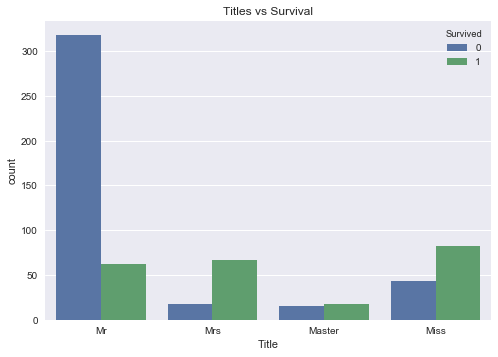

In [70]:
plt.title('Titles vs Survival')
sns.countplot(x='Title',hue='Survived',data=train_data)

Mostly, this is what we expected, with the women and children surviving more than the men. Since it directly states this, it will be left in as a feature.

In [71]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Has_Family,Title,Is_Minor,Num_Family,HasCabin
260,261,0,3,"Smith, Mr. Thomas",male,33.043189,0,0,384461,7.7500,None,Q,Smith,0,Mr,0,0,0
155,156,0,1,"Williams, Mr. Charles Duane",male,51.000000,0,1,PC 17597,61.3792,None,C,Williams,1,Mr,0,1,0
613,614,0,3,"Horgan, Mr. John",male,33.043189,0,0,370377,7.7500,None,Q,Horgan,0,Mr,0,0,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.000000,0,0,345364,6.2375,None,S,Nysveen,0,Mr,0,0,0
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.000000,0,0,250646,13.0000,None,S,Givard,0,Mr,0,0,0


## End of EDA Conclusions:

So at the end of our EDA phase we learned that there are several features in this dataset that are very helpful, and some that while descriptive, overlap too much with other features. Now we have to choose the features we want to include in the model, and build the model accordingly.

Features to be included are: Pclass, Sex, Is_Minor, Has_Family, Embarked, and Title. The reason I have gone with discrete versions of Age and Fare (Is_Minor and Pclass respectively) is that I plan on using a decision tree based model to start. When/if I use logistic regression instead, I will substitute the numerical versions instead.

# Building a Model:

Now we are going to begin building a model that will correctly predict the number of survivors. However, before we do this, we must put the test dataset, test_data, through the same feature engineering and modifications we put the train_data through.

## Feature engineering test_data

In [151]:
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Avg_Ages,Is_Minor,Num_Family,Has_Family,Last_Name
794,795,0,3,"Dantcheff, Mr. Ristiu",male,25.000000,0,0,349203,7.8958,NaN,S,Mr,32.416382,0,0,0,Dantcheff
738,739,0,3,"Ivanoff, Mr. Kanio",male,32.416382,0,0,349201,7.8958,NaN,S,Mr,32.416382,0,0,0,Ivanoff
428,429,0,3,"Flynn, Mr. James",male,32.416382,0,0,364851,7.7500,NaN,Q,Mr,32.416382,0,0,0,Flynn
287,288,0,3,"Naidenoff, Mr. Penko",male,22.000000,0,0,349206,7.8958,NaN,S,Mr,32.416382,0,0,0,Naidenoff
739,740,0,3,"Nankoff, Mr. Minko",male,32.416382,0,0,349218,7.8958,NaN,S,Mr,32.416382,0,0,0,Nankoff


In [152]:
#Generating Title field:
test_data['Title'] = test_data.Name.apply(ExtractTitle)
test_data['Title'] = test_data.Title.apply(CleanTitle)
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Avg_Ages,Is_Minor,Num_Family,Has_Family,Last_Name
794,795,0,3,"Dantcheff, Mr. Ristiu",male,25.000000,0,0,349203,7.8958,NaN,S,Mr,32.416382,0,0,0,Dantcheff
738,739,0,3,"Ivanoff, Mr. Kanio",male,32.416382,0,0,349201,7.8958,NaN,S,Mr,32.416382,0,0,0,Ivanoff
428,429,0,3,"Flynn, Mr. James",male,32.416382,0,0,364851,7.7500,NaN,Q,Mr,32.416382,0,0,0,Flynn
287,288,0,3,"Naidenoff, Mr. Penko",male,22.000000,0,0,349206,7.8958,NaN,S,Mr,32.416382,0,0,0,Naidenoff
739,740,0,3,"Nankoff, Mr. Minko",male,32.416382,0,0,349218,7.8958,NaN,S,Mr,32.416382,0,0,0,Nankoff


In [153]:
#Imputing Age Values by Title
avg_ages_by_title = {'Mr':32.41638225255973,'Mrs':36.46969696969697,'Miss':22.65681818181818,'Master':3.5596428571428573}
test_data['Avg_Ages'] = test_data.Title.apply(lambda title: ImputeAverageAge(title,avg_ages_by_title))
test_data['Age']=test_data.Age.fillna(test_data['Avg_Ages'])

In [154]:
#Generating the Is_Minor and Has_Family features
test_data['Is_Minor'] = test_data.Age.apply(CheckIfMinor)

test_data['Num_Family'] = test_data['SibSp'] + test_data['Parch']
test_data['Has_Family'] = test_data.Num_Family.apply(CheckForFamily)

In [155]:
#Generate the Last_Name feature
test_data['Last_Name'] = test_data.Name.apply(SplitName)
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Avg_Ages,Is_Minor,Num_Family,Has_Family,Last_Name
794,795,0,3,"Dantcheff, Mr. Ristiu",male,25.000000,0,0,349203,7.8958,NaN,S,Mr,32.416382,0,0,0,Dantcheff
738,739,0,3,"Ivanoff, Mr. Kanio",male,32.416382,0,0,349201,7.8958,NaN,S,Mr,32.416382,0,0,0,Ivanoff
428,429,0,3,"Flynn, Mr. James",male,32.416382,0,0,364851,7.7500,NaN,Q,Mr,32.416382,0,0,0,Flynn
287,288,0,3,"Naidenoff, Mr. Penko",male,22.000000,0,0,349206,7.8958,NaN,S,Mr,32.416382,0,0,0,Naidenoff
739,740,0,3,"Nankoff, Mr. Minko",male,32.416382,0,0,349218,7.8958,NaN,S,Mr,32.416382,0,0,0,Nankoff


Now that the base features have been added, lets get the data ready to be analysed

## Getting the Dataframes ready

In [182]:
#Choosing initial features
features_being_used = ['Pclass','Sex','Is_Minor','Has_Family','Embarked','Title']

In [183]:
#Getting the testing and training data ready
target_variable = 'Survived'

y_train = train_data[target_variable]
X_train = train_data[features_being_used]

y_test = test_data[target_variable]
X_test = test_data[features_being_used]

In [184]:
#Dummy the Categorical Variables in X_train and X_test
for var in X_train.columns:
    if X_train[var].dtypes == object:
        X_train[var] = pd.Categorical(X_train[var])
X_train = pd.get_dummies(X_train)

for var in X_test.columns:
    if X_test[var].dtypes == object:
        X_test[var] = pd.Categorical(X_test[var])
X_test = pd.get_dummies(X_test)

C:\Users\amuth\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\amuth\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Now that the data is ready, lets start building the model.

## Base Model: Decision Tree

We'll use a decision tree based model first, as it is easy to visualize and decide which features are important

In [185]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
from sklearn.tree import export_graphviz

In [186]:
dt = DecisionTreeClassifier(random_state=2)
model = dt.fit(X_train,y_train)
pred = model.predict(X_test)
score_base = accuracy_score(pred,y_test)
print('Accuracy is: '+str(score_base))

Accuracy is: 0.8202247191011236


In [187]:
print(classification_report(pred,y_test))

             precision    recall  f1-score   support

          0       0.90      0.82      0.86       181
          1       0.69      0.81      0.74        86

avg / total       0.83      0.82      0.82       267



The base accuracy of our model is =~ 82%. We want to improve that, so lets see if using RandomForest instead works.

## Random Forest Ensemble Model

Essentially a model that uses multiple random decision trees to arrive at a prediction

In [188]:
rf = RandomForestClassifier(random_state=2)
model = rf.fit(X_train,y_train)
pred = model.predict(X_test)
score_base = accuracy_score(pred,y_test)
print('Accuracy is: '+str(score_base))

Accuracy is: 0.8277153558052435


In [189]:
print(classification_report(pred,y_test))

             precision    recall  f1-score   support

          0       0.94      0.81      0.87       191
          1       0.65      0.87      0.74        76

avg / total       0.86      0.83      0.83       267



The random forest model increased the accuracy a little, but not too much. We'll use it in place of the decision tree anyway, in case we decide to try and increase accuracy via hyper-parameter tuning later.

# Prediction Pipeline:

For efficiently analysing all the data we are going to put through this model, we are going to create a Pipepline that will transform, fit, and predict on any data we feed it.

In [231]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier

In [232]:
test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
428,429,0,3,"Flynn, Mr. James",male,NaN,0,0,364851,7.750,NaN,Q
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.775,NaN,S
488,489,0,3,"Somerton, Mr. Francis William",male,30.0,0,0,A.5. 18509,8.050,NaN,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
418,419,0,2,"Matthews, Mr. William John",male,30.0,0,0,28228,13.000,NaN,S


In [233]:
#Extracting the Title from the Age variable:
class Title(TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self,X,y=None):
        X['Title'] = X.Name.apply(ExtractTitle)
        X['Title'] = X.Title.apply(CleanTitle)
        return X
    
    def fit(self,X,y):
        return self

In [234]:
#Imputing Age Values
class Impute_Age(TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self,X,y=None):
        avg_ages_by_title = {'Mr':32.41638225255973,'Mrs':36.46969696969697,'Miss':22.65681818181818,'Master':3.5596428571428573}
        X['Avg_Ages'] = X.Title.apply(lambda title: ImputeAverageAge(title,avg_ages_by_title))
        X['Age']=X.Age.fillna(X['Avg_Ages'])
        return X
    
    def fit(self,X,y):
        return self

In [235]:
#Creating the feature Is_Minor from Age:
class Is_Minor(TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self,X,y=None):
        X['Is_Minor'] = X.Age.apply(CheckIfMinor)
        return X
    
    def fit(self,X,y):
        return self

In [236]:
#Creating the feature Has_Family from SibSp and ParCh:
class Has_Family(TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self,X,y=None):
        X['Num_Family'] = X['SibSp'] + X['Parch']
        X['Has_Family'] = X.Num_Family.apply(CheckForFamily)
        return X
    
    def fit(self,X,y):
        return self

In [237]:
#Keeping only the useful features:
class Prune_Features(TransformerMixin):
    def __init__(self):
        self.features = ['Pclass','Sex','Is_Minor','Has_Family','Embarked','Title']
        pass
    
    def transform(self,X,y=None):
        X = X[self.features]
        return X
    
    def fit(self,X,y):
        return self

In [238]:
#Dummy the Categorical features
class Dummy(TransformerMixin):
    def __init__(self):
        pass
    
    def transform(self,X,y=None):
        '''
        for var in X.columns:
            if X[var].dtypes == object:
                X[var] = pd.Categorical(X[var])
        '''
        X = pd.get_dummies(X)
        return X
    
    def fit(self,X,y):
        return self

In [262]:
#Creating the Pipeline
processor = Pipeline([('title',Title()),
                ('impute_age',Impute_Age()),
                ('is_minor',Is_Minor()),
                ('has_family',Has_Family()),
                ('prune_features',Prune_Features()),
                ('dummy',Dummy()),
                #Decision Tree
                #('dt',DecisionTreeClassifier(random_state=2))
                #Random Forest
                #('rf',RandomForestClassifier(random_state=2))
                #Gradient Boosting
                ('gbc',GradientBoostingClassifier(random_state=2))
                ])

Now that the pipeline is built, lets get the training and testing data ready:

In [263]:
#Training data:
y_train = train_data['Survived']
X_train = train_data.drop(['Survived'],axis=1)

In [264]:
#Testing data:
y_test = test_data['Survived']
X_test = test_data.drop(['Survived'],axis=1)

In [265]:
#Prediction
pipe_model = processor.fit(X_train,y_train)
pred = pipe_model.predict(X_test)
score_base = accuracy_score(pred,y_test)
print('Accuracy is: '+str(score_base))

Accuracy is: 0.8314606741573034


In [266]:
print(classification_report(pred,y_test))

             precision    recall  f1-score   support

          0       0.87      0.87      0.87       171
          1       0.76      0.77      0.77        96

avg / total       0.83      0.83      0.83       267



# Final Run:

We are now going to run the provided test data through the pipeline and submit our results to Kaggle.

In [267]:
final = pd.read_csv('test.csv')

In [268]:
final.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [269]:
pred_final = pipe_model.predict(final)

In [270]:
pred_final

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [271]:
final.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Avg_Ages,Is_Minor,Num_Family,Has_Family
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,32.416382,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,36.469697,0,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,32.416382,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,32.416382,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,36.469697,0,2,1


In [272]:
submission = final.loc[0::,['PassengerId']]

In [273]:
submission.head()

,PassengerId
0,892
1,893
2,894
3,895
4,896


In [274]:
submission['Survived'] = pred_final

In [275]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [276]:
submission.to_csv('Submission.csv')